# Lecture 5: Convolutional networks

Notebook adapted from [Deep Learning (with PyTorch)](https://github.com/Atcold/pytorch-Deep-Learning) by Alfredo Canziani. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# MNIST

In [3]:
tf = transforms.Compose([transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(datasets.MNIST("./data", train=True, transform=tf),
                                           batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(datasets.MNIST("./data", train=False, transform=tf),
                                          batch_size=1000, shuffle=True)

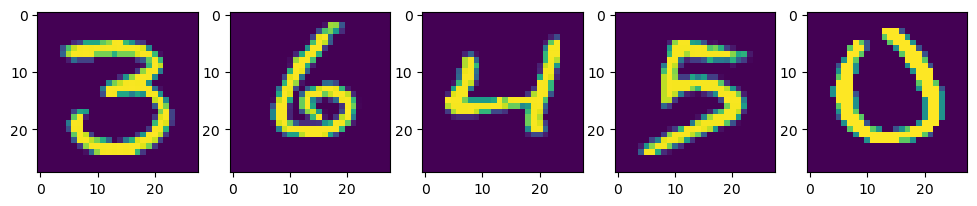

In [4]:
batch = next(iter(train_loader))
x = batch[0][:10]
y = batch[1][:10]

fig, axs = plt.subplots(1, 5, figsize=(12, 4))

for i in range(5):
    axs[i].imshow(x[i].squeeze().numpy())

# MLP vs ConvNet

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super().__init__()
        self.input_size = input_size
        self.net = nn.Sequential(
            nn.Linear(input_size, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
            # nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.net(x)

class ConvNet(nn.Module):
    def __init__(self, input_size, n_kernels, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=n_kernels, out_channels=n_kernels, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(n_kernels * 4 * 4, 50),
            nn.ReLU(),
            nn.Linear(50, 10),
            # nn.Softmax(dim=-1)
        )
        
    def forward(self, x):
        return self.net(x)

In [8]:
def train(model, perm=torch.arange(0, 784).long(), n_epochs=1):
    model.train()    
    optimizer = torch.optim.AdamW(model.parameters())
    
    for epoch in range(n_epochs):
        for i, (data, target) in enumerate(train_loader):
            # send to device
            data, targets = data.to(device), target.to(device)
            print

            # permute pixels
            data = data.view(-1, 28*28)
            data = data[:, perm]
            data = data.view(-1, 1, 28, 28)

            # step
            optimizer.zero_grad()
            logits = model(data)
            print(logits.dtype, logits.shape, targets.dtype, targets.shape)
            
            loss = F.cross_entropy(logits, targets)
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f"epoch={epoch}, step={i}: train loss={loss.item():.4f}")

In [9]:
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    for data, targets in test_loader:
        # send to device
        data, targets = data.to(device), targets.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        # metrics
        logits = model(data)
        test_loss += F.cross_entropy(logits, targets, reduction='sum').item()
        preds = torch.argmax(logits, dim=1)     
        correct += (preds == targets).sum()

    test_loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    print(f"test loss={test_loss:.4f}, accuracy={accuracy:.4f}")

In [10]:
# MLP
input_size = 28*28  
output_size = 10   

n_hidden = 8
mlp = MLP(input_size, n_hidden, output_size)
mlp.to(device)
print(f"Parameters={sum(p.numel() for p in mlp.parameters())/1e3}K")

train(mlp)
test(mlp)

Parameters=6.442K
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
epoch=0, step=0: train loss=2.3063
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torch.Size([64])
torch.float32 torch.Size([64, 10]) torch.int64 torc

In [31]:
# ConvNet, with the same number of parameters
n_kernels = 6
convnet = ConvNet(input_size, n_kernels, output_size)
convnet.to(device)
print(f"Parameters={sum(p.numel() for p in convnet.parameters())/1e3}K")

train(convnet)
test(convnet)

Parameters=6.422K
epoch=0, step=0: train loss=2.3233
epoch=0, step=100: train loss=0.4378
epoch=0, step=200: train loss=0.1719
epoch=0, step=300: train loss=0.2179
epoch=0, step=400: train loss=0.3929
epoch=0, step=500: train loss=0.2728
epoch=0, step=600: train loss=0.1188
epoch=0, step=700: train loss=0.0639
epoch=0, step=800: train loss=0.2077
epoch=0, step=900: train loss=0.1554
test loss=0.1042, accuracy=0.9667


The convolutional network performs better with the same number of parameters, thanks to its use of prior knowledge about images:

* Use of convolution: Locality and stationarity in images
* Pooling: builds in some translation invariance

What if those assumptions are wrong?

# MLP vs ConvNet, on shuffled pixels

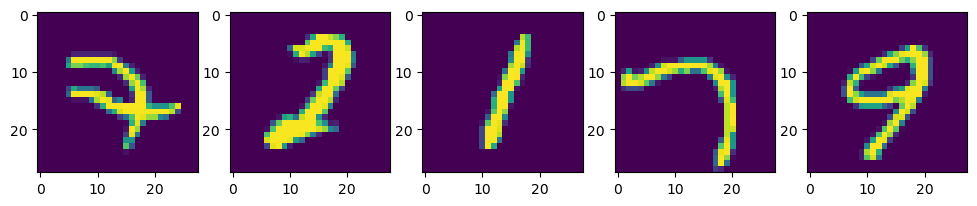

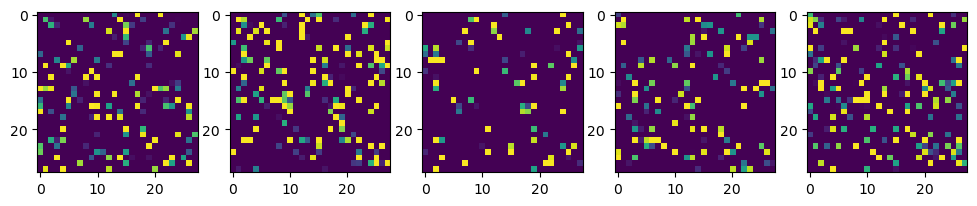

In [32]:
perm = torch.randperm(784)

batch = next(iter(train_loader))
x = batch[0][:10]
y = batch[1][:10]

fig, axs = plt.subplots(1, 5, figsize=(12, 4))

for i in range(5):
    axs[i].imshow(x[i].squeeze().numpy())
    
fig, axs = plt.subplots(1, 5, figsize=(12, 4))
x = x.view(-1, 28*28)
x = x[:, perm]
x = x.view(-1, 1, 28, 28)

for i in range(5):
    axs[i].imshow(x[i].squeeze().numpy())

In [33]:
# ConvNet on shuffled pixels
n_kernels = 6
convnet = ConvNet(input_size, n_kernels, output_size)
convnet.to(device)
print(f"Parameters={sum(p.numel() for p in convnet.parameters())/1e3}K")

train(convnet, perm=perm)
test(convnet, perm=perm)

Parameters=6.422K
epoch=0, step=0: train loss=2.2717
epoch=0, step=100: train loss=1.4825
epoch=0, step=200: train loss=0.9727
epoch=0, step=300: train loss=0.8701
epoch=0, step=400: train loss=0.7045
epoch=0, step=500: train loss=0.5553
epoch=0, step=600: train loss=0.4980
epoch=0, step=700: train loss=0.6311
epoch=0, step=800: train loss=0.2293
epoch=0, step=900: train loss=0.4658
test loss=0.4080, accuracy=0.8724


In [34]:
# MLP on shuffled pixels
input_size = 28*28  
output_size = 10   

n_hidden = 8
mlp = MLP(input_size, n_hidden, output_size)
mlp.to(device)
print(f"Parameters={sum(p.numel() for p in mlp.parameters())/1e3}K")

train(mlp, perm=perm)
test(mlp, perm=perm)

Parameters=6.442K
epoch=0, step=0: train loss=2.3154
epoch=0, step=100: train loss=1.5152
epoch=0, step=200: train loss=0.6278
epoch=0, step=300: train loss=0.4071
epoch=0, step=400: train loss=0.4127
epoch=0, step=500: train loss=0.3370
epoch=0, step=600: train loss=0.2718
epoch=0, step=700: train loss=0.4750
epoch=0, step=800: train loss=0.2036
epoch=0, step=900: train loss=0.3137
test loss=0.3322, accuracy=0.9019


The convolutional network's performance drops when we permute the pixels, but the MLP's performance stays the same.
* ConvNet makes the assumption that pixels lie on a grid and are stationary/local.
* It loses performance when this assumption is wrong.
* The fully-connected network does not make this assumption.
* It does less well when it is true, since it doesn't take advantage of this prior knowledge.
* But it doesn't suffer when the assumption is wrong.